## Sentinel 2 TOA high resolution imagery

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References

### Overview

Sentinel 2 TOA high resolution imagery captures high-resolution images of land surfaces across 13 spectral bands, providing observations every 5 days or faster. The two satellites are in polar orbits, 180 degrees apart, allowing them to monitor both land and coastal waters with frequent revisits. The satellites cover latitudes between 56°S and 84°N, capturing images in 13 spectral bands at varying resolutions: 4 bands at 10 m, 6 at 20 m, and 3 at 60 m. The orbital swath spans 290 km. The Level 1C (L1C) images are ortho-rectified, 100x100 km tiles spatially registered to a global reference system, representing the conditions at the top of the atmosphere. The dataset currently ingests only Band 10 (SWIR 1370 nm) tiles, with timestamps rounded to 0:00 UTC, corresponding to the satellite’s sensing time.



### Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [1]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import numpy as np
import pandas as pd
import datetime
import configparser
import ibmpairs.client as client  # represents an authenticated HTTP client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import matplotlib.pyplot as plt

from PIL import Image as Image
from IPython.display import Image as Img


def now():
    return datetime.datetime.utcnow().isoformat()


print(f"Current time: {now()}")
print("Imports initialized.")

Current time: 2025-02-17T17:51:51.342085
Imports initialized.


### Get authentication token

In [3]:
config = configparser.RawConfigParser()
config.read("../../../../auth/secrets.ini")
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY = config.get("EI", "api.api_key")
EI_TENANT_ID = config.get("EI", "api.tenant_id")
EI_ORG_ID = config.get("EI", "api.org_id")

EI_client_v3 = client.get_client(
    api_key=EI_API_KEY,
    tenant_id=EI_TENANT_ID,
    org_id=EI_ORG_ID,
    legacy=False,
    version=3
)

2025-02-17 23:21:55 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-02-17 23:21:55 - paw - INFO - Legacy Environment is False
2025-02-17 23:21:55 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-02-17 23:21:57 - paw - INFO - Authentication success.
2025-02-17 23:21:57 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


### Data layers

To get started, we’ll first explore the **catalog sub-module** of the `ibmpairs` library. This will allow us to retrieve the **dataset_id** and the associated **datalayer(s)** that comprise the dataset we’re interested in querying. By identifying the correct dataset and its structure, we can ensure that we are working with the right data for our analysis. 

Let’s walk through this process step by step.

In [4]:
# search for datasets by name
filter_catalogue_search_df = catalog.search("Sentinel 2 TOA high resolution imagery")
filter_catalogue_search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,176,50096,Band 10 (SWIR 1370 nm),"Central wavelength 1373.5/1376.9 nm, bandwidth...",20,Raster,,Sentinel 2 TOA high resolution imagery,Images from the European Space Agency (ESA) Se...


As shown above, the Data Set with ID 176 contains single Data Layer with ID 50096. To gain a better understanding of the Data Set, including its geospatial and temporal coverage, as well as other relevant metadata, we can perform additional queries in the catalog submodule, as outlined in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

### Querying the data layers

#### Point query
Next, let us make a point query for location in the southern part of the San Francisco Bay Area, near Morgan Hill in California to observe different bands in satellite imaging.

In [5]:
# Submit the query
query_result = query.submit(
    {
        "layers": [
            {
                "type": "raster", 
                "id": "50096"
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                37.0499, -121.1342
            ]  # point somewhere in the southern part of the San Francisco Bay Area
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2024-01-01T00:00:00Z", 
                    "end": "2024-01-02T00:00:00Z"
                }
            ]
        }
    },
    client=EI_client_v3
)


# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()

# Convert the timestamp to a human readable format as datetime
point_df["datetime"] = pd.to_datetime(point_df["timestamp"] * 1e6, errors="coerce", utc=True)
point_df["datetime"] = point_df["datetime"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df = point_df.drop(columns=["timestamp"])

# The datetime column will be placed in the middle of the dataFrame, while keeping all other columns in their original order.
datetime_col = "datetime"
columns = point_df.columns.tolist()
columns.remove(datetime_col)
middle_index = len(columns) // 2
columns.insert(middle_index, datetime_col)

point_df = point_df[columns]
point_df

2025-02-17 23:23:15 - paw - INFO - TASK: submit STARTING.
2025-02-17 23:23:17 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,datetime,longitude,latitude,value
0,50096,Band 10 (SWIR 1370 nm),Sentinel 2 TOA high resolution imagery,2024-01-01T00:00:00Z,-121.1342,37.0499,0.001000


#### Raster query

Next, we'll perform a raster query for location in the southern part of the San Francisco Bay Area, near Morgan Hill in California to observe different bands in satellite imaging.


In [6]:
SentinelL1CResult = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Sentinel 2 TOA high resolution imagery in the southern part of the San Francisco Bay Area",
        "spatial": {
            "type": "square",
            "coordinates": [
                37.0499, -121.1342,
                37.1489, -121.0317
            ] # location to a region somewhere in the southern part of the San Francisco Bay Area
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2024-01-01T00:00:00Z", 
                    "end": "2024-01-02T00:00:00Z"
                }
            ]
        },
        "layers": [
            {
                "type": "raster", 
                "id": "50096", 
                "output": True
            }
        ]
    },
    client=EI_client_v3
)

2025-02-17 23:24:05 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-02-17 23:24:07 - paw - INFO - The query was successfully submitted with the id: 1739793600_21246908.
2025-02-17 23:24:08 - paw - INFO - The query 1739793600_21246908 has the status Queued.
2025-02-17 23:24:39 - paw - INFO - The query 1739793600_21246908 has the status Succeeded.
2025-02-17 23:24:39 - paw - INFO - The query 1739793600_21246908 was successful after checking the status.
2025-02-17 23:25:10 - paw - INFO - The query 1739793600_21246908 has the status Succeeded.
2025-02-17 23:25:10 - paw - INFO - The query 1739793600_21246908 was successful after checking the status.
2025-02-17 23:25:10 - paw - INFO - The query download folder is set to the path /Users/raunakbhansali/Documents/GitHub/Environmental-Intelligence-internal/geospatial/samples/v3/datasets/esa_sentinel_2_l1c/download/.
2025-02-17 23:25:12 - paw - INFO - The query 1739793600_21246908 is a zip.
2025-02-17 23:25:12 - paw - INFO - 

In [11]:
SentinelL1CResult_file_list = SentinelL1CResult.list_files()
output_image_array = []
for file in SentinelL1CResult_file_list:
    if file.endswith(".tiff"):  # display the raster images
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)
        boundingBox = fileparms["boundingBox"]
        pixelStatistics = fileparms["rasterStatistics"]
        # Check if pixelMin and pixelMax are valid (not None)
        if pixelStatistics is not None:
            myextent = [
                boundingBox["minLongitude"],
                boundingBox["maxLongitude"],
                boundingBox["minLatitude"],
                boundingBox["maxLatitude"],
            ]
            arrayGFS = np.array(Image.open(file))
            mask = arrayGFS == -9999

            # Masked array to exclude NO Data points from plotting
            masked_array = np.ma.masked_array(arrayGFS, mask)
            plt.figure(
                figsize=(20, 9), dpi=80
            )  # Sets the size and resolution of the plot
          
            plt.imshow(
                masked_array,
                cmap="viridis",
                vmin=pixelStatistics["pixelMin"],
                vmax=pixelStatistics["pixelMax"],
                extent=myextent,
            )
            # Loads the raster data and sets the colormap
            plt.colorbar()  # Adds the color bar
            plt.title(" " + os.path.basename(file))
            # Create a unique output image path using the file name
            output_image_path = os.path.basename(file) + "_image.png"
            output_image_array.append(output_image_path)

            # Save the figure
            plt.savefig(output_image_path, bbox_inches="tight")
            plt.close()

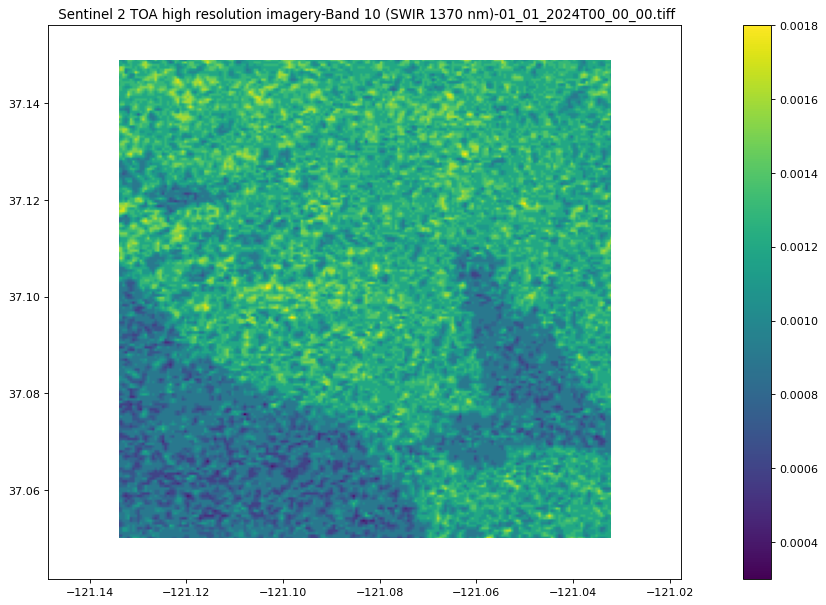

In [12]:
for output_image in output_image_array:
    # display the raster images
    display(Img(output_image, width=600, height=300))

The raster image above generated from band SWIR 1370 nm that will provide a nuanced view of the landscape's moisture content, vegetation health, and soil conditions, depending on the time of year and environmental factors.

### References

- https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/
- https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L1C.html